In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [2]:
#standard imports
import time
import numpy as np
import h5py


In [3]:
#We're not using the GPU here, so we set the 
#"CUDA_VISIBLE_DEVICES" environment variable to -1
#which tells tensorflow to only use the CPU

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

## Gradient Descent

In [5]:
#let's define a model which "believes" that the output data
#is scalar power of a scalar input, e.g. :
#      y ~ x^p

#defining the scalar input data variable 
batch_size = 200

#the "placeholder" mechanis is similar in effect to
#            x = tf.get_variable('x', shape=(batch_size,), dtype=tf.float32)
#except we don't have to define a fixed name "x"
x = tf.placeholder(shape=(batch_size,), dtype=tf.float32)

#define the scalar power variable
initial_power = tf.zeros(shape=())
power = tf.get_variable('pow', initializer=initial_power, dtype=tf.float32)

#define the model
model = x**power

#the output data needs a variable too
y = tf.placeholder(shape=(batch_size,), dtype=tf.float32)

In [6]:
#the error rate of the model is mean L2 distance across 
#the batch of data
power_loss = tf.reduce_mean((model - y)**2)

In [17]:
#now, our goal is to use gradient descent to 
#figure out the parameter of our model -- namely, the power variable
grad = tf.gradients(power_loss, power)[0]

In [11]:
#Let's fit (optimize) the model.   
#to do that we'll have to first of course define a tensorflow session
sess = tf.Session()

In [12]:
#... and initialize the power variable
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [14]:
#ok ... so let's test the case where the true input-output relationship
#is x --> x^2
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2

In [18]:
#OK
initial_guess = 0
assign_op = tf.assign(power, initial_guess)
sess.run(assign_op)

gradval = sess.run(grad, feed_dict={x: xval, y: yval})

In [11]:
gradval

-1.5306325

In [19]:
#ok so this is telling us to do:

new_guess = initial_guess + -1 * (gradval)
print(new_guess)

1.53063249588


In [20]:
#ok so let's assign the new guess to the power variable
assign_op = tf.assign(power, new_guess)
sess.run(assign_op)

#... and get the gradient again
gradval = sess.run(grad, feed_dict={x: xval, y: yval})

gradval

-0.56193405

In [21]:
new_guess = new_guess + -1 * (gradval)
print(new_guess)

2.09256654978


In [22]:
#... and one more time ...
assign_op = tf.assign(power, new_guess)
sess.run(assign_op)

#... get the gradient again
gradval = sess.run(grad, feed_dict={x: xval, y: yval})
print('gradient: %.3f', gradval)

#... do the update
new_guess = new_guess + -1 * (gradval)
print('power: %.3f', new_guess)

#ok so we're hovering back and forth around guess of 2.... which is right!

('gradient: %.3f', 0.17790559)
('power: %.3f', 1.9146609604358673)


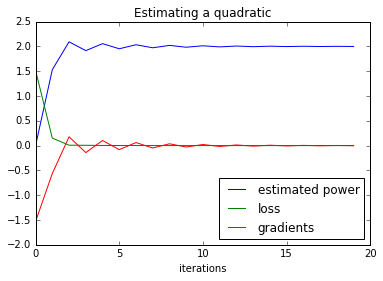

In [27]:
#OK let's do this in a real loop and keep track of useful stuff along the way
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2

#start the guess off at 0 again
assign_op = tf.assign(power, 0)
sess.run(assign_op)

#let's keep track of the guess along the way
powers = []

#and the loss, which should go down
losses = []

#and the grads just for luck
grads = []

#let's iterate the gradient descent process 20 timesteps
num_iterations = 20

#for each timestep ...
for i in range(num_iterations):
    
    #... get the current derivative (grad), the current guess of "power"
    #and the loss, given the input and output training data (xval & yval)
    cur_power, cur_loss, gradval = sess.run([power, power_loss, grad], 
                                        feed_dict={x: xval, y: yval})

    #... keep track of interesting stuff along the way
    powers.append(cur_power)
    losses.append(cur_loss)
    grads.append(gradval)
    
    #... now do the gradient descent step
    new_power = cur_power - gradval
    
    #... and actually update the value of the power variable
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
    #and then, the loop runs again
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.plot(grads, label='gradients')
plt.xlabel('iterations')
plt.legend(loc='lower right')
plt.title('Estimating a quadratic')

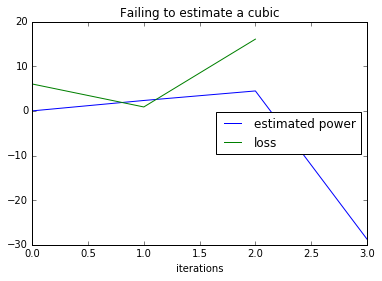

In [28]:
##ok now let's try that again except where y ~ x^3

#all we need to do is change the data
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3

#The rest of the code remains the same
assign_op = tf.assign(power, 0)
sess.run(assign_op)

powers = []
losses = []
grads = []

num_iterations = 20
for i in range(num_iterations):    
    cur_power, cur_loss, gradval = sess.run([power, power_loss, grad], 
                                        feed_dict={x: xval, y: yval})
    powers.append(cur_power)
    losses.append(cur_loss)
    grads.append(gradval)

    new_power = cur_power - gradval

    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.xlabel('iterations')
plt.legend(loc='center right')
plt.title('Failing to estimate a cubic')
    
#wait ... this did *not* work.  why? 

In [29]:
#whoa ... the loss must have diverged to infinity (or close) really early
losses
#why? 

[6.0235572,
 0.87862968,
 16.070698,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [19]:
#let's look at the gradients
grads
#hm.  the gradient was getting big at the end. 

[-2.3299172,
 -2.1364195,
 33.202091,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [20]:
#after all, the taylor series only works in the close-to-the-value limit. 
#we must have been been taking too big steps.  
#how do we fix this? 

### With Learning Rate

In [45]:
def gradient_descent(loss, 
                     target,
                     initial_guess,
                     learning_rate,
                     training_data,
                     num_iterations):
    
    #assign initial value to the target
    initial_op = tf.assign(target, initial_guess)

    #get the gradient
    grad = tf.gradients(loss, target)[0]
    
    #actually do the gradient descent step directly in tensorflow
    newval = tf.add(target, tf.multiply(-grad, learning_rate))
    
    #the optimizer step actually performs the parameter update
    optimizer_op = tf.assign(target, newval)
    
    #NB:  none of the four steps above are actually running anything yet
    #They are just formal graph computations. 
    #to actually do anything, you have to run stuff in a session. 
 
    #set up containers for stuff we want to keep track of
    targetvals = []
    losses = []
    gradvals = []
    
    #first actually run the initialization operation
    sess.run(initial_op)
    
    #now take gradient steps in a loop
    for i in range(num_iterations):
        #just by virtue of calling "run" on the "optimizer" op, 
        #the optimization occurs ... 
        output = sess.run({'opt': optimizer_op,
                           'grad': grad, 
                           'target': target,
                           'loss': loss
                          }, 
                          feed_dict=training_data)
        targetvals.append(output['target'])
        losses.append(output['loss'])
        gradvals.append(output['grad'])
                
    return losses, targetvals, gradvals
    

In [43]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3
data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                         target=power,
                                         initial_guess=0,
                                         learning_rate=.1,
                                         training_data=data_dict,
                                         num_iterations=20)

In [44]:
sess.run(power)

0.0

In [37]:
powers

[0.23299173,
 0.43095851,
 0.62494576,
 0.82338095,
 1.0301416,
 1.2472076,
 1.4751247,
 1.7126933,
 1.9561515,
 2.1980307,
 2.4262788,
 2.6251397,
 2.779768,
 2.8839216,
 2.9441545,
 2.9747372,
 2.9889567,
 2.9952524,
 2.9979744,
 2.9991386]

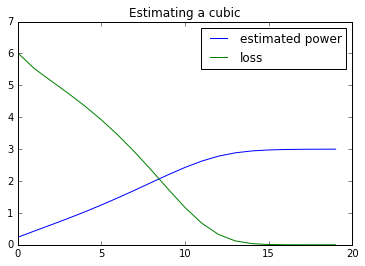

In [33]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3
data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                         target=power,
                                         initial_guess=0,
                                         learning_rate=.1,
                                         training_data=data_dict,
                                         num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title('Estimating a cubic')

#ok -- now the result stably converges!

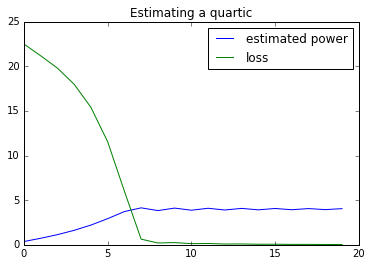

In [82]:
#and also for a higher power .... 
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**4
data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                         target=power,
                                         initial_guess=0,
                                         learning_rate=0.1,
                                         training_data=data_dict,
                                         num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title('Estimating a quartic')

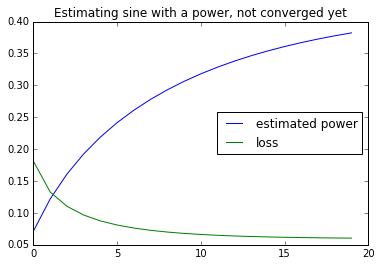

In [83]:
#what about when the data is actually not of the right form?

xval = np.arange(0, 2, .01)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                          target=power,
                                          initial_guess=0,
                                          learning_rate=0.1,
                                          training_data=data_dict,
                                          num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
plt.title('Estimating sine with a power, not converged yet')

#doesn't look like it's converged yet -- maybe we need to run it longer? 

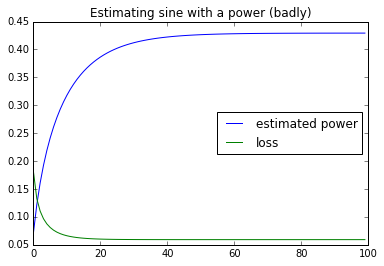

In [84]:
#sine(x) now with more iterations

xval = np.arange(0, 2, .01)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                        target=power,
                                        initial_guess=0,
                                        learning_rate=0.1,
                                        training_data=data_dict,
                                        num_iterations=100)  #<-- more iterations

plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
plt.title('Estimating sine with a power (badly)')

#ok it's converged but not to a great loss.  This is unsurprising 
#since x^p is a bad model for sine(x)

In [26]:
#how should we improve? 
#THE MACHINE LEARNING ANSWER:  well, let's have more parameters in our model!

#actually, let's write a model using the Taylor series idea more explicitly:
#    y ~ sum_i a_i x^i  
#for some coefficients a_i that we have to learn

In [27]:
#let's go out to x^5, so approx_order = 7 (remember, we're 0-indexing in python)
approximation_order = 6

#ok so now let's define the variabe we'll be using
#instead of "power" this will be coefficients of the powers
#with one coefficient for each power from 0 to approximation_order-1
coefficients = tf.get_variable('coefficients', 
                        initializer = tf.zeros(shape=(approximation_order,)),
                        dtype=tf.float32)

In [173]:
#gotta run the initializer again b/c we just defined a new trainable variable
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [29]:
#Ok let's define the model

#here's the vector of exponents
powervec = tf.range(0, approximation_order, dtype=tf.float32)

#we want to do essentially:
#     sum_i coefficient_i * x^powervec[i]
#but to do x^powervec, we need to create an additional dimension on x
x_expanded = tf.expand_dims(x, axis=1)

#ok, now we can actually do x^powervec
x_exponentiated = x_expanded**powervec

#now multiply by the coefficient variable
x_multiplied_by_coefficients = coefficients * x_exponentiated

#and add up over the 1st dimension e.g. dong the sum_i
polynomial_model = tf.reduce_sum(x_multiplied_by_coefficients, axis=1)

#the loss is again l2 difference between prediction and desired output
polynomial_loss = tf.reduce_mean((polynomial_model - y)**2)

In [174]:
xval = np.arange(-2, 2, .02)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

#starting out at 0 since the coefficients were all intialized to 0
sess.run(polynomial_model, feed_dict=data_dict)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [110]:
#ok let's try it
losses, coefvals, grads = gradient_descent(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        learning_rate=0.1,  
                                        training_data=data_dict,
                                        num_iterations=100)  


In [111]:
#ok, so for each timstep we have 6 values -- the coefficients
print(len(coefvals))

coefvals[-1].shape

100


(6,)

In [112]:
#here's the last set of coefficients learned
coefvals[-1]
#whoa -- what's going on?  

array([ nan,  nan,  nan,  nan,  nan,  nan], dtype=float32)

In [113]:
#let's lower the learning rate
losses, coefvals, grads = gradient_descent(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        learning_rate=0.005,  #<-- lowered learning rate
                                        training_data=data_dict,
                                        num_iterations=100)  


In [114]:
#ok not quite as bad
coefvals[-1]

array([-0.00102979,  0.25239715, -0.00184434,  0.20770763,  0.00133661,
       -0.032684  ], dtype=float32)

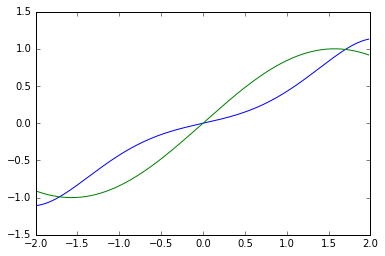

In [115]:
#let's visualize what we learned
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

#ok, fine, but not great

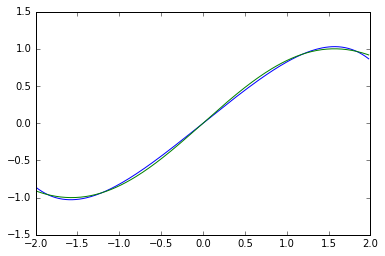

In [116]:
#what if we let it run longer? 
losses, coefvals, grads = gradient_descent(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        learning_rate=0.005,  
                                        training_data=data_dict,
                                        num_iterations=5000)  #<-- more iterations

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

#ok much better

### Tensorflow's Built-In Optimizers

In [65]:
def tf_builtin_optimization(loss,
                            optimizer_class,
                            target,
                            training_data,
                            num_iterations,
                            optimizer_args=(),
                            optimizer_kwargs={},
                           ):
    
    #construct the optimizer
    optimizer = optimizer_class(*optimizer_args, 
                                **optimizer_kwargs)
    #formal tensorflow optimizers will always have a "minimize" method
    #this is how you actually get the optimizer op
    optimizer_op = optimizer.minimize(loss)
    
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    targetvals = []
    losses = []
    for i in range(num_iterations):
        output = sess.run({'opt': optimizer_op,
                           'target': target,
                           'loss': loss}, 
                          feed_dict=training_data)
        targetvals.append(output['target'])
        losses.append(output['loss'])
                
    return np.array(losses), targetvals

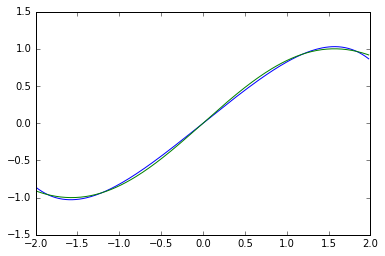

In [71]:
xval = np.arange(-2, 2, .02)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.GradientDescentOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=5000,
                              optimizer_args=(0.005,),
                              )  #<-- more iterations

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

#right ok, we recovered what we did before by hand, now using
#the standard tensorflow tools

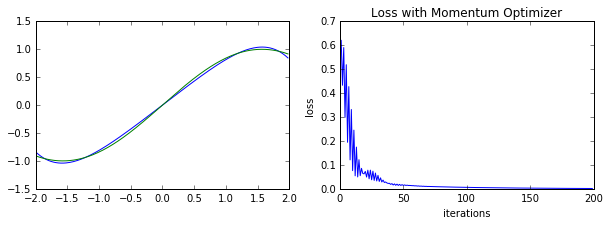

In [158]:
#Let's use the Momentum Optimizer. standard parameters for learning 
#are learning_rate = 0.01 and momentum = 0.9

xval = np.arange(-2, 2, .02)
yval = np.sin(xval )
data_dict = {x: xval, y:yval}

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.MomentumOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=200, #<-- notice many fewer iteratins
                              optimizer_kwargs={'learning_rate': 0.01,
                                                'momentum': 0.9}) 
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Momentum Optimizer')

#basically momentum allows us to get away with a higher initial learning rate 
#(and thus fewer iterations) without blowing up

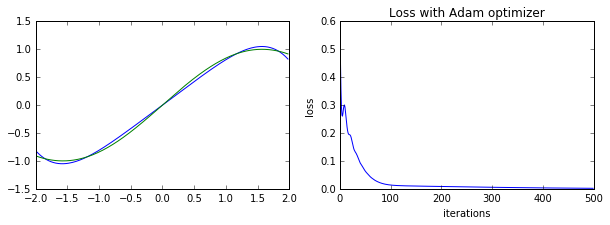

In [157]:
#and we can try some other stuff, such as the Adam Optimizer

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.AdamOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=500,
                              optimizer_kwargs={'learning_rate': 0.01})                                            
                            
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Adam optimizer')

#Adam as usualy requires a bit more steps than Momentum -- but the advantage of Adam
#is that sometimes Momentum blows up and Adam is usually more stable
#(compare the loss traces! even though Momentum didn't below up above, it's
#loss is much more jaggedy -- signs up potential blowup)

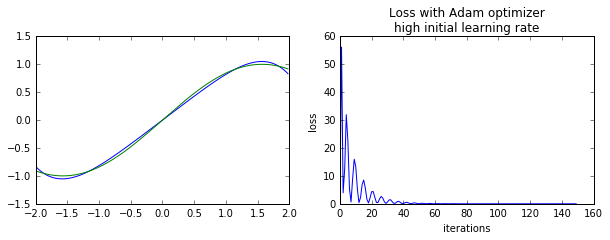

In [166]:
#so hm ... maybe because Adam is more stable we can jack up the 
#initial learning rate and thus converge even faster than with Momentum

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.AdamOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=150,
                              optimizer_kwargs={'learning_rate': 0.5})                                            
                            
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Adam optimizer\nhigh initial learning rate')

#indeed we can!

### Newton's Method  (Second Order)

In [168]:
def newtons_method(loss, 
                   target,
                   initial_guess,
                   training_data,
                   num_iterations,
                   grad2clip=1.):
    
    #create initialization operation
    initial_op = tf.assign(target, initial_guess)    

    grad = tf.gradients(loss, target)[0]
    #to actually compute the second order correction 
    #we split the one-variable and multi-variable cases up -- for ease of working
    
    if len(target.shape) == 0:   #one-variable case
        #actually get the second derivative
        grad2 = tf.gradients(grad, target)[0]
        
        #now morally we want to compute:
        #    newval = target - grad / grad2
        #BUT there is often numerical instability caused by dividing
        #by grad2 if grad2 is small... so we have to clip grad2 by a clip value
        clippedgrad2 = tf.maximum(grad2, grad2clip)
        
        #and now we can do the newton's formula update
        newval = tf.add(target, -tf.divide(grad, clippedgrad2))
    else:
        #in the multi-variable case, we first compute the hessian matrix
        #thank gosh tensorflow has this built in finally!
        hess = tf.hessians(loss, target)[0]
        #now we take it's inverse
        hess_inv = tf.matrix_inverse(hess)
        #now we get H^{-1} grad, e.g. multiple the matrix by the vector
        hess_inv_grad = tf.tensordot(hess_inv, grad, 1)
        #again we have to clip for numerical stability
        hess_inv_grad = tf.clip_by_value(hess_inv_grad, -grad2clip, grad2clip)
        #and get the new value for the parameters
        newval = tf.add(target, -hess_inv_grad)
    
    #the rest of the code is just as in the gradient descent case
    optimizer_op = tf.assign(target, newval)    
    targetvals = []
    losses = []
    gradvals = []
    sess.run(initial_op)
    for i in range(num_iterations):        
        output = sess.run({'opt': optimizer_op,
                           'grad': grad, 
                           'target': target,
                           'loss': loss}, 
                          feed_dict=training_data)
        targetvals.append(output['target'])
        losses.append(output['loss'])
        gradvals.append(output['grad'])
    return losses, targetvals, gradvals


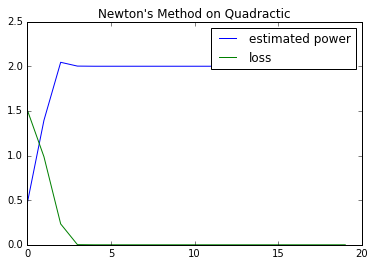

In [169]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2
data_dict = {x: xval, y:yval}

losses, powers, grads = newtons_method(loss=power_loss,
                                       target=power,
                                       initial_guess=0,
                                       training_data=data_dict,
                                       num_iterations=20,
                                       grad2clip=1)


plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title("Newton's Method on Quadractic")

#whoa -- much faster than before

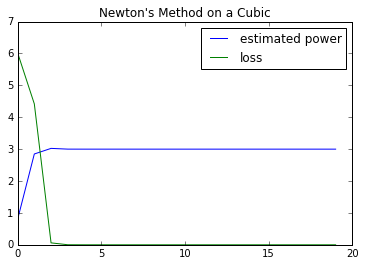

In [172]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3
data_dict = {x: xval, y:yval}

losses, powers, grads = newtons_method(loss=power_loss,
                                       target=power,
                                       initial_guess=0,
                                       training_data=data_dict,
                                       num_iterations=20,
                                       grad2clip=1)


plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title("Newton's Method on a Cubic")


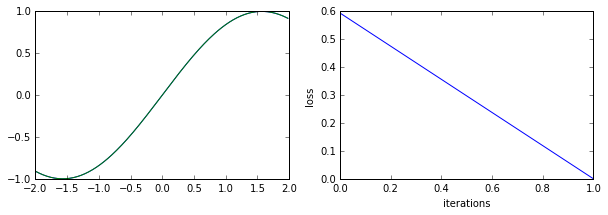

In [139]:
xval = np.arange(-2, 2, .02)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, coefvals, grads = newtons_method(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        training_data=data_dict,
                                        num_iterations=2)

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

#no joke -- the error goes to 0 after 1 update step


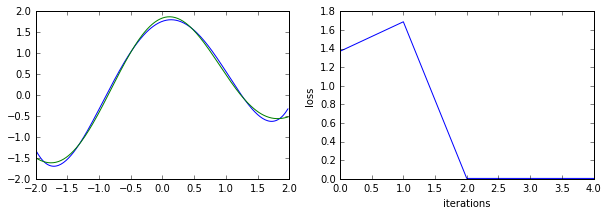

In [141]:
#let's try something a little more complicated 

xval = np.arange(-2, 2, .02)
yval = np.cos(2 * xval) + np.sin(xval + 1)

data_dict = {x: xval, y:yval}

losses, coefvals, grads = newtons_method(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        training_data=data_dict,
                                        num_iterations=5)

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

#really fast -- actually Newton's method always converges this fast if
#the model is polynomial


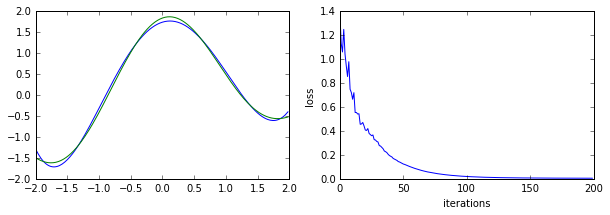

In [144]:
#just to put the above in context, let's compare to momentum

xval = np.arange(-2, 2, .02)
yval = np.cos(2 * xval) + np.sin(xval + 1)

data_dict = {x: xval, y:yval}

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.MomentumOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=200,
                              optimizer_kwargs={'learning_rate': 0.01,
                                                'momentum': 0.9},
                              ) 
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

### Quasi-Second Order methods (L-BFGS)